# Heat Equation on a metric graph solver: Example Graph
by Fabian Visser
5/11/20


In [1]:
%matplotlib notebook

import numpy as np
import scipy as sc
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML


## To Edit
Here are the variables the that the user can edit to change the graph and certain conditions on the graph.

In [10]:
sources = np.array([1, 2, 2, 1]) #Starting points of edges
targets = np.array([2, 3, 4, 1]) #Endpoints of edges, in this case we have 4 vertices, and 3 edges
#Length of each edge
L1 = 5
L2 = 5
L3 = 5
L4 = 2*np.pi
#No. of discretization points of each edge
N1 = 20
N2 = 20
N3 = 20
N4 = 20
#Boundary conditions of each vertex, 0 implies Kirchhoff BC and np.nan implies Neumann BC
BC = [0, 0, np.nan, np.nan]
#Length in time
T = 30
#Discretization of time
nt = 1000
#Initial conditions, unique on each edge
f = lambda x : [5*np.exp(-5*(x-2.5)**2), np.zeros(len(x)), np.zeros(len(x)), np.zeros(len(x))]



L = np.array([L1, L2, L3, L4])
N = np.array([N1, N2, N3, N4])


## Graph Class

In [11]:
#Defining Graph class
class Graph:
    
    #Define Graph.Nodes and Graph.Edges
    def __init__(self, source, target, L, N, BC):
        self.Nodes = self.Nodes(source, target, BC) 
        self.Edges = self.Edges(source, target, L, N, BC)

    #Graph.Nodes will hold all the information of the vertices of the graph
    class Nodes:
        def __init__(self, source, target, BC):    
            self.Vertices = sorted(list(set(source) | set(target))) #Collection of vertices of the graph
            self.BC = BC #Boundary conditions of each vertex of the graph
            self.junctIndic = np.nan_to_num(BC,nan=-1)+1 #Indicator function checking if the vertex is a junction
            self.junctNo = np.count_nonzero(self.junctIndic) #Number of junction vertices
            self.x1 = [] #x-position of vertices
            self.x2 = [] #y-position of vertices  
            self.y = [None] * len(self.Vertices) #z-position of vertices (the solution)


    
    #Graph.Edges will hold all the information of the edges of the graph
    class Edges:
        def __init__(self, source, target, L, N, BC):    
            self.EndNodes = np.column_stack((source, target)) #Collection of starting and endpoints of edges of Graph
            self.L = L #Length of Edge
            self.nx = [None] * len(N) #Number of discretization points of each edge EXCLUDING nodes with kirchhoff boundary conditions
            self.dx = [None] * len(L) #Dx of each edge
            self.x = [None] * len(L) #Discretized points
            self.xn = [None] * len(L) #Number of discretization points of each edge WITHOUT the nodes
            self.x1 = [] #x-position of each point on each edge
            self.x2 = [] #y-position of each point on each edge
            #Calculating nx,dx,x, and xn
            BC = np.nan_to_num(BC,nan=-1)+1
            for i in range(0,len(L)): 
                LNode = int(BC[self.EndNodes[i][0]-1])
                RNode = int(BC[self.EndNodes[i][1]-1])
                excpoints = LNode+RNode
                self.nx[i] = N[i]-excpoints
                self.dx[i] = L[i]/(N[i]-1)
                self.x[i] = np.linspace(self.dx[i]*LNode, L[i]-self.dx[i]*RNode, self.nx[i]) #discretized points excluding junctions
                self.xn[i] = np.linspace(self.dx[i], L[i]-self.dx[i], N[i]-2)   
            
            
            
            
    #Create the graph in 3d space for plotting
    #This section has to be uniquely written for each graph.
    
    def addjunctCoords(self, L):
        #Placing the Nodes in 3d space
        self.Nodes.x1 = np.array([-L[0], 0, 1, 1])
        self.Nodes.x2 = np.array([0, 0, (L[1]**2-1)**(1/2), -(L[2]**2-1)**(1/2)])
        
        #Placing the Edges in 3d space
        x1 = self.Edges.xn[0]

        x2 = self.Edges.xn[1]

        x3 = self.Edges.xn[2]
        
        x4 = self.Edges.xn[3]

        #values of edges in the x-direction
        L1X1 = -L[0] + x1
        L2X1 = x2/L[1]
        L3X1 = x3/L[2]
        L4X1 =  np.cos(x4)-6

        #values of edges in the y-direction
        L1X2 = np.zeros(np.size(x1))
        L2X2 = (x2**2-L2X1**2)**(1/2)
        L3X2 = -(x3**2-L3X1**2)**(1/2)
        L4X2 = np.sin(x4)

        self.Edges.x1 = np.array([L1X1, L2X1, L3X1, L4X1])
        self.Edges.x2 = np.array([L1X2, L2X2, L3X2, L4X2]) 

## Functions

In [12]:
#Creates Laplacian of Graph
#Applies central differences on edges, and forward on junctions
def GraphLaplacian(G):
    nx = G.Edges.nx
    nxC = np.insert(np.cumsum(nx),0,[0]) #Cumulative sum of discretized points
    nxTot = nxC[-1]+G.Nodes.junctNo #Total number of discretized points of graph
    dx=G.Edges.dx;
    M = np.zeros([nxTot,nxTot]) #The Laplacian we will eventually have
    p = 0 #Counter
    #Central difference of points that aren't junctions
    for k in range(0,len(G.Edges.EndNodes)):
        n = nx[k]
        e = np.ones(n)
        A = (np.diag(np.delete(e,0),-1)+np.diag(-2*e)+np.diag(np.delete(e,0),1))/dx[k]**2
        M[nxC[k]:nxC[k+1],nxC[k]:nxC[k+1]]=A;
    
    #Central difference of junctions
    for j in range(1,len(G.Nodes.Vertices)+1):
        if ~np.isnan(G.Nodes.BC[j-1]):
            degreeHere = len(np.where(G.Edges.EndNodes == j)[0]) #Degree of Node
            allEdges = np.where(G.Edges.EndNodes == j)[0]+1 #Which edges are present at Node
            inOrOut = np.where(G.Edges.EndNodes == j)[1] #Whether the edges enter or leave Node
            for neighbor in range(0,degreeHere): #Looping over each edge
                colBranch = allEdges[neighbor]
                colDirection = inOrOut[neighbor]
                if colDirection == 1: #edge is entering the node
                    col1 = nxC[colBranch]
                    col2 = col1-1
                if colDirection == 0: #edge is leaving the node
                    col1 = nxC[colBranch-1]+1
                    col2 = col1+1
            #Applying central difference on junctions and points before/after the junctions
                M[nxC[-1]+p,col1-1] = M[nxC[-1]+p,col1-1] + 1 / (G.Edges.dx[colBranch-1]**2)
                M[col1-1,nxC[-1]+p] = 1 / G.Edges.dx[colBranch-1]**2
            M[nxC[-1]+p,nxC[-1]+p]= sum([(1 / (G.Edges.dx[i-1]**2) - 2 / (G.Edges.dx[i-1]**2)) for i in allEdges])
            p = p+1
    return(M)

#Calculates the solution
def calcSol(G,M,t,f):
    Dt = t[1]
    nxC = np.insert(np.cumsum(G.Edges.nx),0,[0]) #Cumulative sum of discretized points
    nxTot = nxC[-1]+G.Nodes.junctNo #Total number of discretized points of graph
    r = np.zeros(nxTot) #Contains information on the Neumann BC
    u = [] #Will contain the solution
    p=0
    for h in range(0,len(G.Edges.L)):
        u = np.hstack((u,f(G.Edges.x[h])[h]))

    #Form f and g into a list where the junction counts once
    for j in range(1,len(G.Nodes.Vertices)+1):
        if ~np.isnan(G.Nodes.BC[j-1]): #Looking at junctions specifically
            degreeHere = len(np.where(G.Edges.EndNodes == j)[0]) #Degree of Node
            allEdges = np.where(G.Edges.EndNodes == j)[0][0] #Which edges are present at the node
            inOrOut = np.where(G.Edges.EndNodes == j)[1][0] #Whether the edges enter or leave the node
            if inOrOut == 1: #edge is entering the node
                x = np.array([G.Edges.x[allEdges][-1]+G.Edges.dx[allEdges]])
                fjunct = f(x)[allEdges]
            if inOrOut == 0: #edge is leaving the node
                fjunct = f(np.array([0]))[allEdges]
            u = np.hstack((u,fjunct))
                    
        else: #Looking at Neumann boundary points
            allEdges = np.where(G.Edges.EndNodes == j)[0][0] #Which edges are present at the node
            inOrOut = np.where(G.Edges.EndNodes == j)[1][0] #Whether the edges enter or leave the node
            if inOrOut == 1: #edge is entering the node
                r[nxC[allEdges+1]-1] = f(G.Edges.x[allEdges])[allEdges][-1] / (G.Edges.dx[allEdges]**2)
            if inOrOut == 0: #edge is leaving the node
                r[nxC[allEdges]] = f(G.Edges.x[allEdges])[allEdges][0] / (G.Edges.dx[allEdges]**2)
    def f(t,u):
        v = np.dot(M,u)+r
        return v
    #Applying RK4
    W = sc.integrate.solve_ivp(f,[t[0],t[-1]],u,t_eval=t)
    return np.fliplr(np.rot90(W.y, k=-1))
    

#Calculate x1,x2,y values for edge i
def PlotGraph(G,W,i):
    nxC = np.insert(np.cumsum(G.Edges.nx),0,[0]) #Cumulative sum of discretized points
    bc = np.nan_to_num(G.Nodes.BC,nan=-1)+1
    y = W[nxC[i]:nxC[i+1]] #The solution on the ith edge
    x1 = [] #x-direction
    x2 = [] #y-direction
    
    #The solution y does not contain the nodes with Kirchhoff BC yet, since they are at the end of W. We will now include them
    lnode = G.Edges.EndNodes[i][0]
    rnode = G.Edges.EndNodes[i][1]
    LNode = bc[lnode-1]
    RNode = bc[rnode-1]
    if LNode == 1: #If the left node of the edge has a Kirchhoff BC
        p = np.sum(bc[0:lnode], dtype=int)
        y = np.hstack((W[nxC[-1]+p-1],y))
    if RNode == 1: #if the right node of the edge has a kirchhoff BC
        p = np.sum(bc[0:rnode], dtype=int)
        y = np.hstack((y,W[nxC[-1]+p-1]))  
    #Fill in x1, x2, and y
    x1l = G.Nodes.x1[lnode-1]
    x1r = G.Nodes.x1[rnode-1]
    x1 = np.hstack((x1l, G.Edges.x1[i], x1r))
    x2l = G.Nodes.x2[lnode-1]
    x2r = G.Nodes.x2[rnode-1]
    x2 = np.hstack((x2l, G.Edges.x2[i], x2r))  
    return [x1,x2,y]

## Calculating solution

In [13]:
t = np.linspace(0,T,nt)
G = Graph(sources, targets, L, N, BC)
G.addjunctCoords(L)

#Calculate Laplacian
M = GraphLaplacian(G)

#Calculate solution over all edges
W = calcSol(G,M,t,f)



## Grapher

<IPython.core.display.Javascript object>


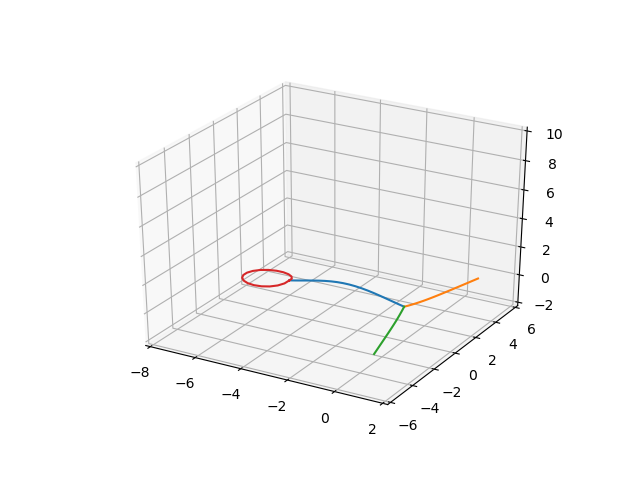

In [14]:
#Taken from https://towardsdatascience.com/how-to-create-animated-graphs-in-python-bb619cc2dec1
fig = plt.figure()
ax = fig.gca(projection='3d', xlim = [-8,2], ylim = [-6,6], zlim = [-2,10])
Graphline = [ax.plot([],[],[])[0] for _ in range(0,len(L))]
def init():
    for line in Graphline:
        line.set_data_3d([], [], [])        
    return Graphline

def animate(i): #Timeframe
    for j,line in enumerate(Graphline): #Over each edge ("line")
        [x1,x2,y] = PlotGraph(G, W[i-1], j)
        line.set_data_3d(x1,x2,y)
    return Graphline
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(t), interval=10)

#To save the file
#writervideo = animation.FFMpegWriter(fps=60) 
#anim.save("HeatExample.mp4")
#HTML(anim.to_html5_video())

## Laplacian (Optional)

<IPython.core.display.Javascript object>


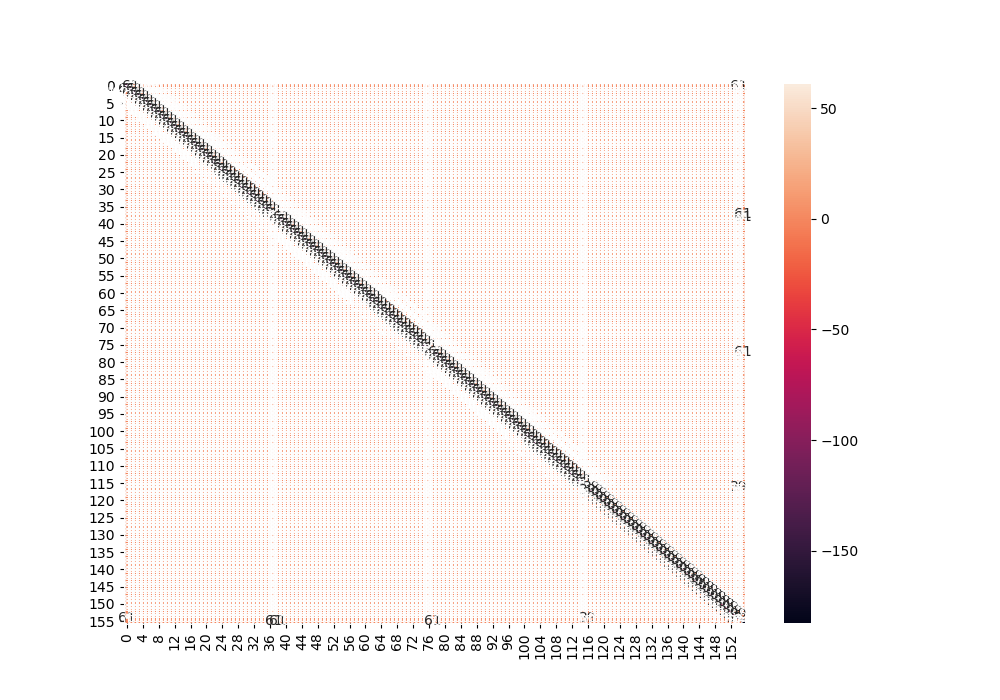

In [182]:
df_cm = pd.DataFrame(M)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.show()